<a href="https://colab.research.google.com/github/ravipatel2/node/blob/master/GA_Final_Project_Predicting_Wind_Power_Output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Wind Power Output
*By: Ravi Patel* 

**Note:**
This version of the file I am uploading does not include the extreme gradient boosting version because I was running into issues with fixing the code and allowing it enough time to run. I have left the code in this notebook, but it has not been run and has been turned into comment text. 

## 1. Problem Statement

Predicting the power output of wind turbines is a challenging task for the renewable energy industry. Inaccurate forecasting can result in potential revenue losses for energy companies and higher electricity prices for consumers due to supply/demand imbalances. While energy companies that operate wind generation assets have highly advanced tools to help them predict wind power output during operations, a simplified model has many applications for cost-benefit analyses to initially evaluate an energy project at a particular site. In particular, this benefits regions where access to data may be limited, such as emerging markets. The ability to develop a simple yet relatively accurate predictive model can help evaluate and develop a potential renewable energy project. 

## 2. Approach Overview

### 2.1 Data Source
Wind turbines, as well as other power generation and industrial equipment, are equipped with supervisory control and data acquisition (SCADA) systems, computer systems for gathering and analyzing real time data. SCADA data from a wind turbine operating in Yalova, Turkey was provided through [Kaggle](https://www.kaggle.com/berkerisen/wind-turbine-scada-dataset). The dataset provides the following information: 

- **Date/Time (at 10 minute intervals)**
- **LV_Active_Power (kW)**: power produced in the 10 minute interval
- **Wind Speed (m/s)**: wind speed at a given 10-minute interval
- **Theoretical Power Curve (kW)**: theoretical power values that the turbine generates with a particular wind speed; provided by turbine manufacturer
- **Wind Direction (°)**: wind direction at the hub height of the turbine (wind turbines turn to this direction automatically) 


### 2.2 Target Variable
This model will focus on predicting the LV_Active_Power at a given wind speed. Understanding the power output is critical for understanding the project economics of a wind project to determine if it has the potential to provide the expected return rate. 

### 2.3 Feature Variables
As the goal of this is to develop a relatively accurate model with limited features, this analysis focuses on using only the recorded wind speed and the theoretical power curve provided by the wind manufacturer. The advantage of these 2 variables as features is that they allow for the development of a model that can compare multiple turbines from various manufacturers when evaluating a project. The added optionality of understanding how different wind turbines can perform would provide potential ranges of power output from the asset and impact project economics.  

### 2.4 Model Approach
Predicting the wind power output poses a regression problem. Three different models were developed, tested, and evaluated as part of this project. 
1. Linear Regression: train-test-split and cross-validation
2. Random Forest Regression
3. Extreme Gradient Boosting 

## 3. Data Preparation

In [22]:
!pip install windrose

In [23]:
# Set up the notebook and import the necessary packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from windrose import WindroseAxes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import xgboost as xgb

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [24]:
from google.colab import files
uploaded = files.upload()

Saving wind_scada.csv to wind_scada (1).csv


In [25]:
import io
wind = pd.read_csv(io.BytesIO(uploaded['wind_scada.csv']))

In [26]:
# Read in the file and update the column names
wind= wind.rename(columns={"Date/Time": 'date_time',
                           "LV ActivePower (kW)": "lv_active_power",
                        "Wind Speed (m/s)": "wind_speed",
                        "Theoretical_Power_Curve (KWh)": "theoretical_power_curve",
                        "Wind Direction (°)": "wind_direction"})

# Convert the date_time column to datetime objects and split them by date and time
wind['date_time'] = pd.to_datetime(wind['date_time'])
wind['date'] = wind['date_time'].dt.date
wind['time'] = wind['date_time'].dt.time

# Remove lv_active_power values that are less than zero, as active power cannot be negative. 
wind = wind[wind['lv_active_power']>=0]

# Check for any missing values 
wind.isnull().sum()

date_time                  0
lv_active_power            0
wind_speed                 0
theoretical_power_curve    0
wind_direction             0
date                       0
time                       0
dtype: int64

In [27]:
# Look over the cleaned dataset. 
wind.describe()

,lv_active_power,wind_speed,theoretical_power_curve,wind_direction
count,50473.000000,50473.000000,50473.000000,50473.000000
mean,1309.161489,7.563317,1493.846082,123.648102
std,1312.463427,4.226509,1367.885865,93.446383
min,0.000000,0.000000,0.000000,0.000000
25%,52.740540,4.210382,163.084179,49.304878
50%,828.006714,7.111886,1067.161300,73.660378
75%,2484.364014,10.303410,2966.774233,201.684006
max,3618.732910,25.206011,3600.000000,359.997589


## 4. Exploratory Data Analysis

**Visualizing Wind Direction and Speed:** 
In order to interpret both the wind direction and speed together, we will use a wind rose graphic. The circular format of the wind rose shows the direction the winds blew from and the length of each "spoke" around the circle shows how often the wind blew from that direction.

*Python has a package called windrose that makes it simple to develop a graphic with the right data. See here for [documentation](https://pypi.org/project/windrose/).*

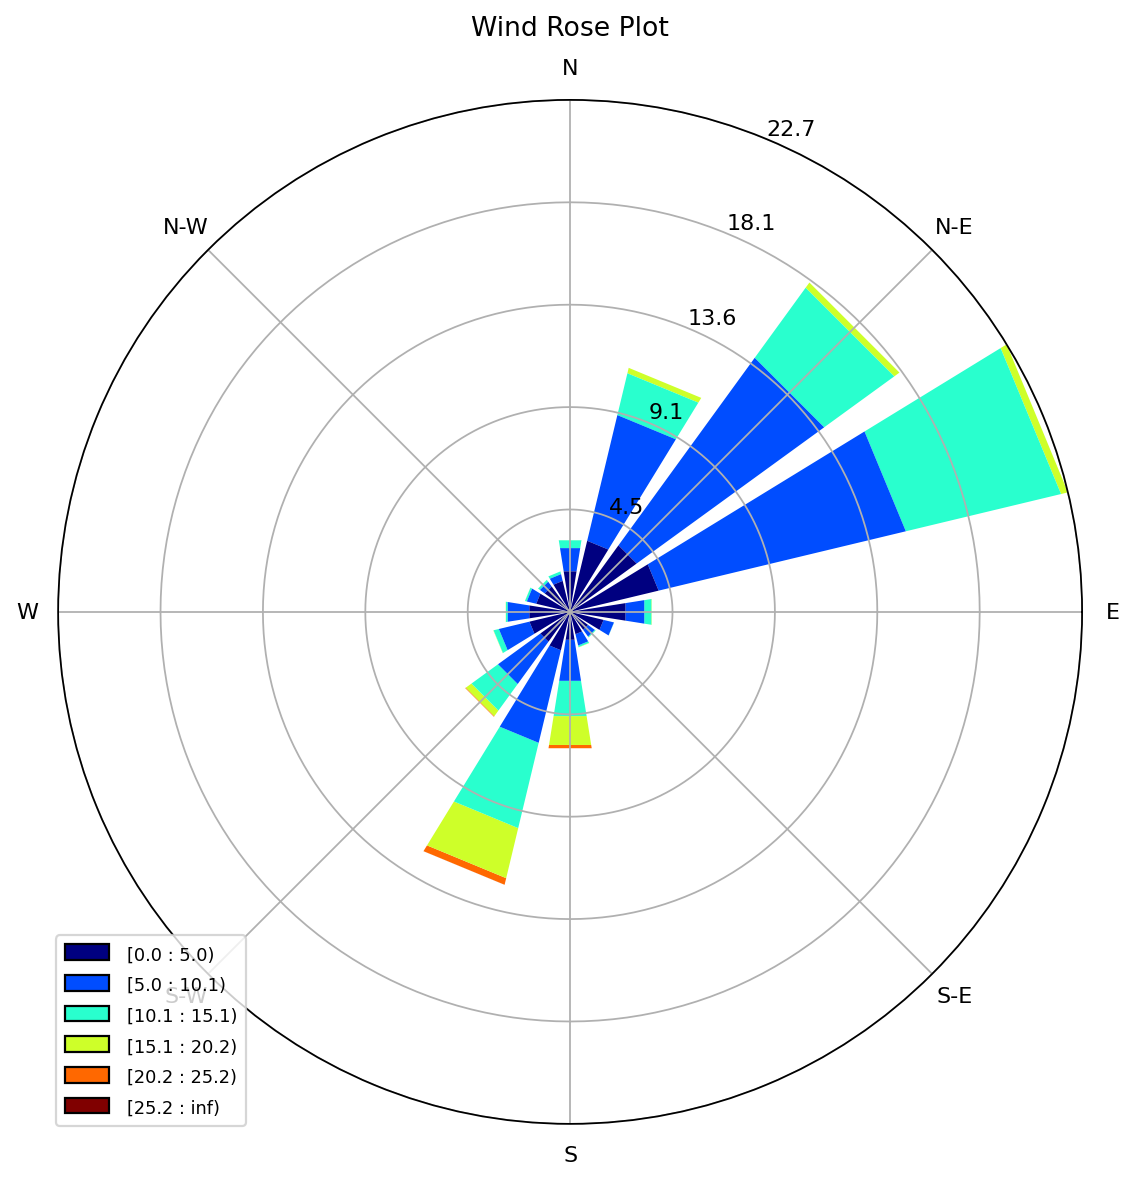

In [28]:
ax = WindroseAxes.from_ax()
ax.bar(wind['wind_direction'], 
       wind['wind_speed'],
       normed=True, 
       opening=0.8)
ax.set_legend()
ax.set_title('Wind Rose Plot');

**Organizing Data:**
To explore our data, it will be helpful to understand summary statistics about the dataset grouped differently to understand how we can use this info as we develop a model.

In [29]:
# Define a function to round the recorded wind speed to 1 decimal place and create a new column with that info. 
def round_speed(x):
    list=[]
    i=0.25
    while i<=25.5:
        list.append(i)
        i+=0.5
        
    for i in list:
        if x < i:
            x=i-0.25
            return x

wind["rounded_windspeed"]=wind["wind_speed"].apply(round_speed)

# Define a function to round the bucket the wind direction values in increments of 30 degrees to separate them by
# direction. 
def round_direction(x):
    list=[]
    i=15
    while i<=375:
        list.append(i)
        i+=30
        
    for i in list:
        if x < i:
            x=i-15
            if x==360:
                return 0
            else:
                return x
wind["rounded_direction"]=wind["wind_direction"].apply(round_direction)

# Define a function to convert the mean direction values to string directional values (e.g., N, S, E, W) and create 
# a new column with this information. 
def direction(x):
    if x==0:
        return "N"
    if x==30:
        return "NNE"
    if x==60:
        return "NEE" 
    if x==90:
        return "E" 
    if x==120:
        return "SEE" 
    if x==150:
        return "SSE" 
    if x==180:
        return "S" 
    if x==210:
        return "SSW" 
    if x==240:
        return "SWW" 
    if x==270:
        return "W" 
    if x==300:
        return "NWW" 
    if x==330:
        return "NNW"
    
wind["direction"]=wind["rounded_direction"].apply(direction)

In [30]:
# Create a summary data frame by speed bins we created

summary_speed = wind.groupby("rounded_windspeed")
wind_speed_summary =summary_speed.mean()

# Remove any unnecessary columns
wind_speed_summary.drop(columns={"wind_speed",
                                 "wind_direction",
                                 "rounded_direction"},
                        inplace=True)

# Create a wind speed column from the index values
list_wind_speed = wind_speed_summary.index.copy()
wind_speed_summary["wind_speed"] = list_wind_speed

# Update the order of columns
wind_speed_summary = wind_speed_summary[["wind_speed",
                                         "lv_active_power",
                                         "theoretical_power_curve"]]
# Update index numbers
wind_speed_summary["Index"]=list(range(1,len(wind_speed_summary.index)+1))
wind_speed_summary.set_index("Index",inplace=True)

# Round column values
wind_speed_summary=wind_speed_summary.round({"wind_speed": 1, 
                                             "lv_active_power": 2, 
                                             "theoretical_power_curve": 2})

# Create a count column to show the number of wind speed occurrences
wind_speed_summary["count"]=[len(wind["rounded_windspeed"][wind["rounded_windspeed"]==i])
                               for i in wind_speed_summary["wind_speed"]]

In [31]:
wind_speed_summary.head(3)

,wind_speed,lv_active_power,theoretical_power_curve,count
Index,,,,
1,0.0,0.0,0.0,15
2,0.5,0.0,0.0,399
3,1.0,0.0,0.0,947


In [32]:
wind_speed_summary.tail(3)

,wind_speed,lv_active_power,theoretical_power_curve,count
Index,,,,
49,24.0,3601.32,3600.0,10
50,24.5,3602.02,3600.0,1
51,25.0,3600.78,3600.0,1


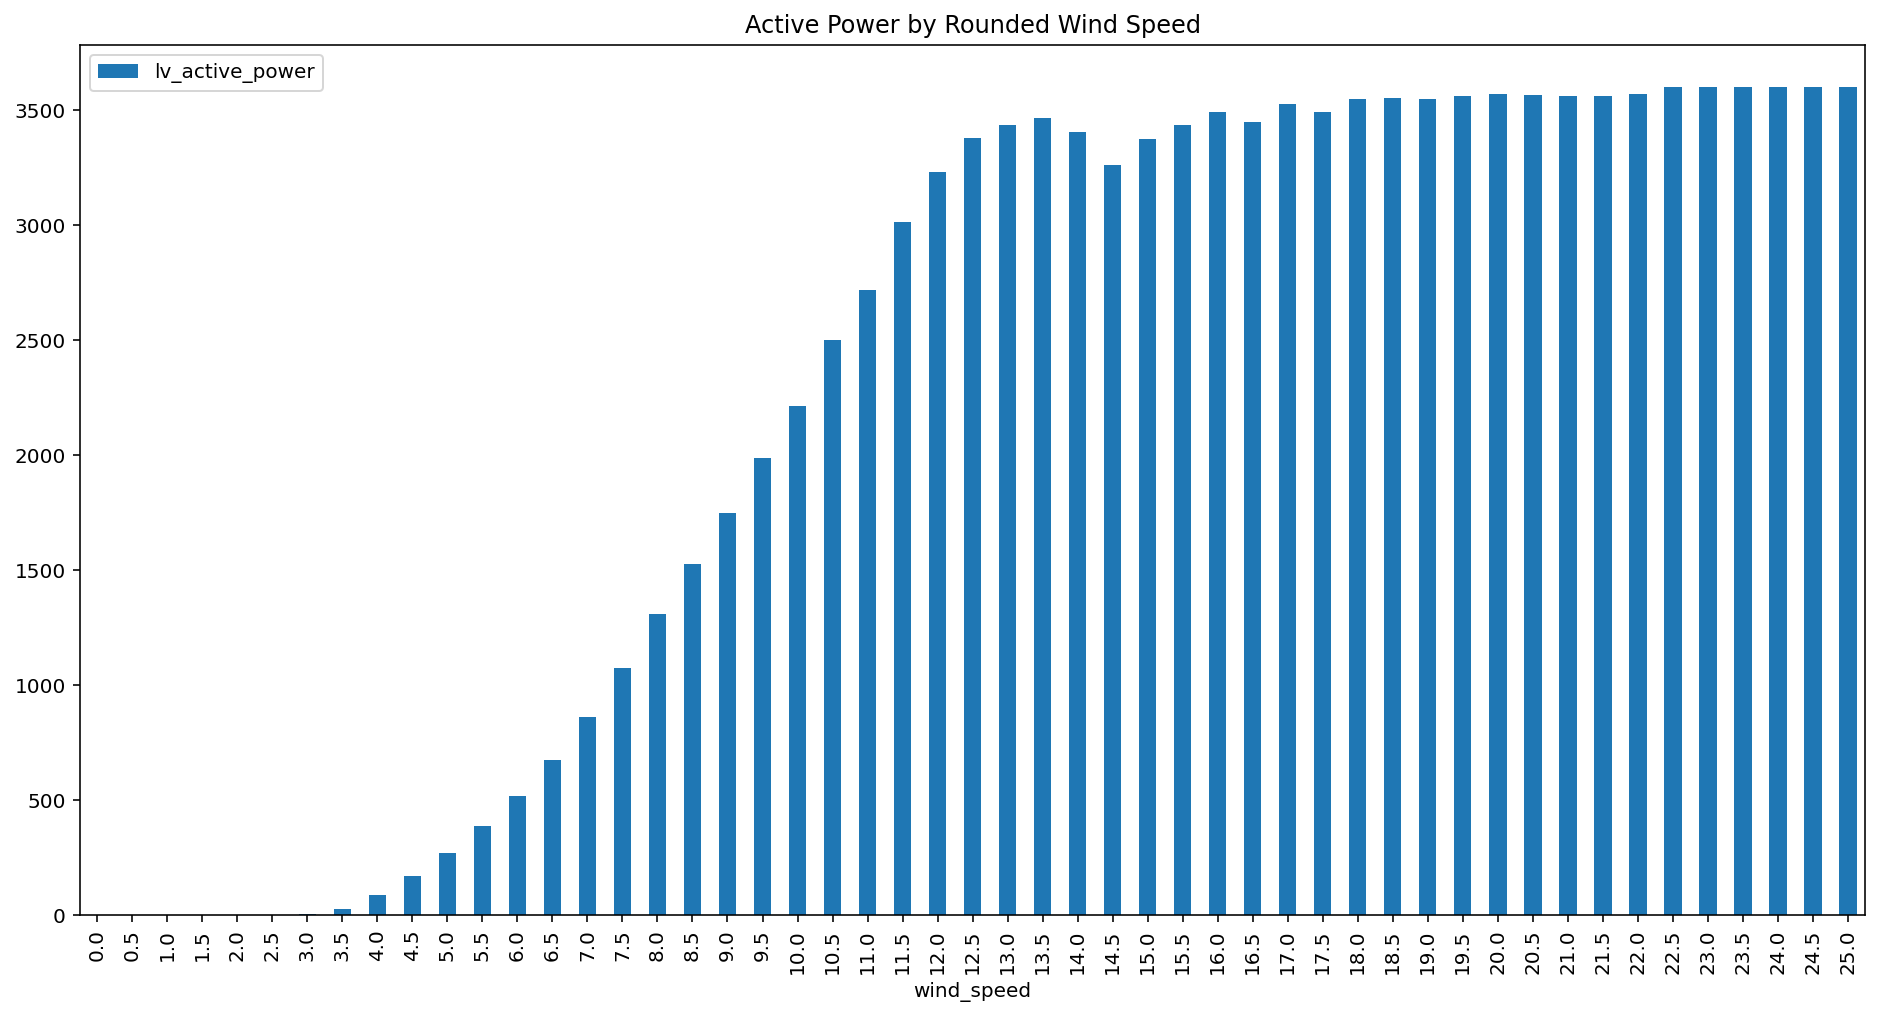

In [33]:
# Look at the average active power by the rounded wind speed 
wind_speed_summary.plot(kind='bar', 
                        x='wind_speed',
                       y='lv_active_power',
                       figsize=(16,8),
                       title='Active Power by Rounded Wind Speed');

In [34]:
wind.head(3)

,date_time,lv_active_power,wind_speed,theoretical_power_curve,wind_direction,date,time,rounded_windspeed,rounded_direction,direction
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,2018-01-01,00:00:00,5.5,270,W
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,2018-01-01,00:10:00,5.5,270,W
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,2018-01-01,00:20:00,5.0,270,W


In [35]:
# Create a summary data frame by direction bins we created. 

summary_dir = wind.groupby("direction")
wind_dir_summary = summary_dir.mean()

# Remove the unnecessary columns.
wind_dir_summary.drop(columns={"wind_speed",
                               "wind_direction"},
                        inplace=True)

# Create a wind direction column from index values
list_wind_dir = wind_dir_summary.index.copy()
wind_dir_summary["direction"] = list_wind_dir

# Change the place of columns
wind_dir_summary = wind_dir_summary[["direction",
                                     "rounded_direction",
                                     "lv_active_power",
                                     "theoretical_power_curve",
                                     "rounded_windspeed"]]
# Change the index numbers
wind_dir_summary["Index"]=list(range(1,len(wind_dir_summary.index)+1))
wind_dir_summary.set_index("Index",inplace=True)

# Round the values to 2 digits
wind_dir_summary = wind_dir_summary.round({"rounded_direction": 1, 
                                             "lv_active_power": 2, 
                                             "theoretical_power_curve": 2})

# Create a count column that shows the number of wind speed occurrences in each category
wind_dir_summary["count"]=[len(wind["direction"][wind["direction"]==i])
                               for i in wind_dir_summary["rounded_direction"]]

# Sort the rounded_direction column and drop the rounded_direction column
wind_dir_summary = wind_dir_summary.sort_values("rounded_direction")
wind_dir_summary.drop('rounded_direction', inplace=True, axis=1)

In [36]:
wind_dir_summary

,direction,lv_active_power,theoretical_power_curve,rounded_windspeed,count
Index,,,,,
2,N,656.90,823.19,5.314422,0
4,NNE,1199.77,1501.91,7.523594,0
3,NEE,1565.47,1770.29,8.187060,0
1,E,747.69,890.45,5.714117,0
8,SEE,244.76,290.48,3.757563,0
9,SSE,438.73,509.26,4.380863,0
7,S,2093.08,2202.94,10.491924,0
10,SSW,2002.41,2179.92,10.009883,0
11,SWW,818.88,963.71,5.872349,0


**Power Flow Analysis**
Building a power flow analysis allows us to obtain a  high level summary of the the daily average power output from the wind turbine.

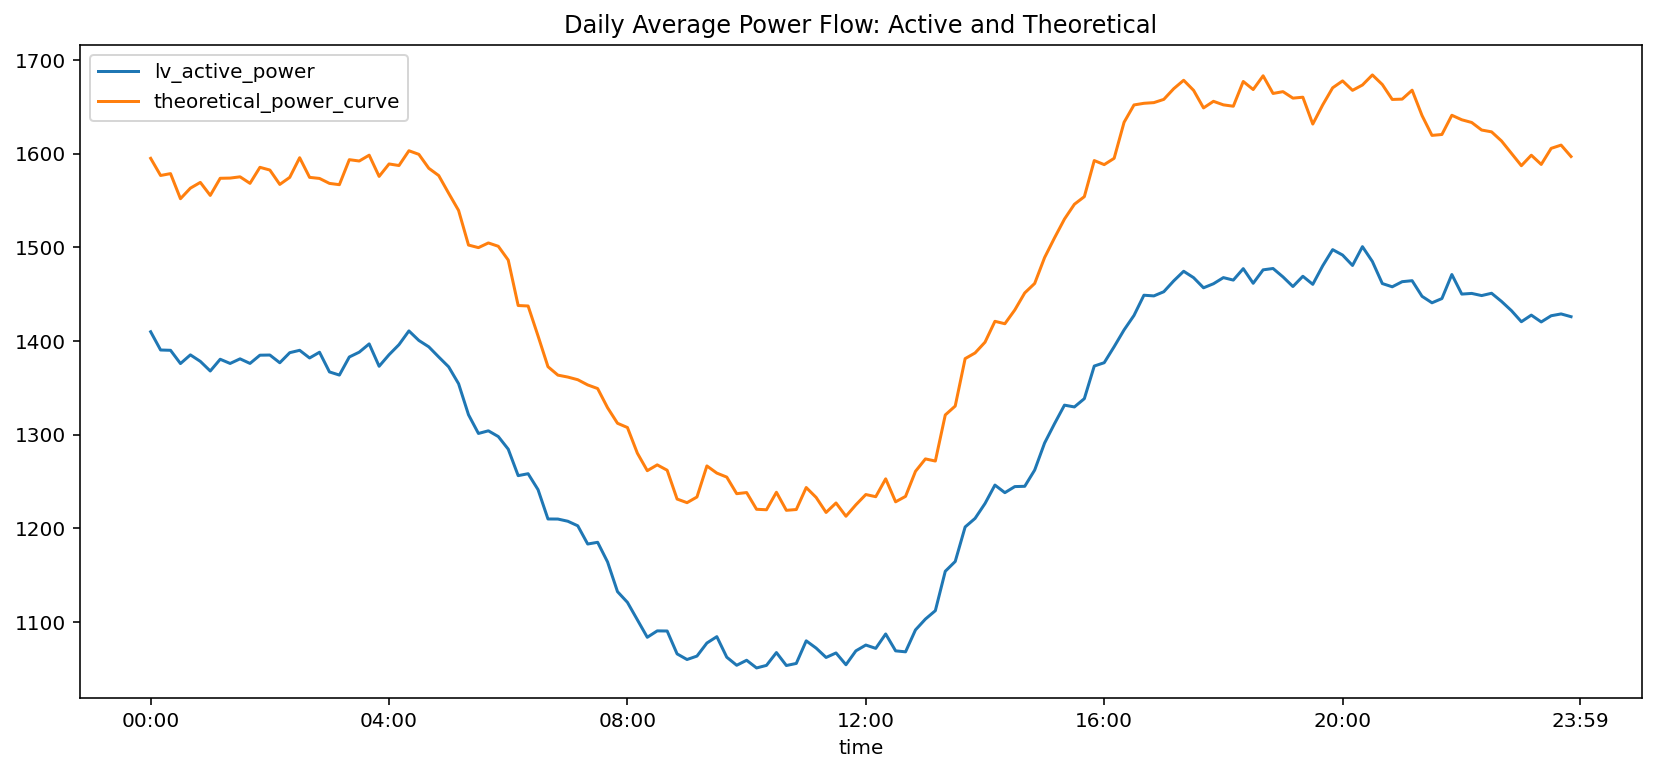

In [37]:
# Using the groupby method and the plotting method, create a graph that shows the daily average power flow
ax = wind.groupby('time').mean().plot(y=['lv_active_power', 'theoretical_power_curve'],
                                     figsize=(14,6))
ax.set_title('Daily Average Power Flow: Active and Theoretical')
ax.set_xticks(['00:00', '04:00', '8:00', '12:00', '16:00', '20:00', '23:59']);

In [38]:
# Lastly, update the name of the summary frame to reflect mean active power 
wind_speed_summary.rename(columns={'lv_active_power': 'mean_active_power'},
                         inplace=True)
wind_speed_summary.head(10)

,wind_speed,mean_active_power,theoretical_power_curve,count
Index,,,,
1,0.0,0.00,0.00,15
2,0.5,0.00,0.00,399
3,1.0,0.00,0.00,947
4,1.5,0.00,0.00,1383
5,2.0,0.05,0.00,1812
6,2.5,0.50,0.00,2108
7,3.0,4.77,11.19,2167
8,3.5,25.64,53.27,1983
9,4.0,86.12,127.32,1982


## 4. Model Development

In [39]:
# Before developing the model, let's merge the wind speed summary dataframe with the wind dataframe to add in the
# corresponding mean active power
join_frame = wind_speed_summary[['wind_speed', 'mean_active_power']]
join_frame.rename(columns={'wind_speed':'rounded_windspeed'},
                 inplace=True)
wind_model_data = wind.merge(join_frame)
wind_model_data.head(3)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date_time,lv_active_power,wind_speed,theoretical_power_curve,wind_direction,date,time,rounded_windspeed,rounded_direction,direction,mean_active_power
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,2018-01-01,00:00:00,5.5,270,W,385.07
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,2018-01-01,00:10:00,5.5,270,W,385.07
2,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,2018-01-01,00:30:00,5.5,270,W,385.07


In [40]:
wind_model_data.describe()

,lv_active_power,wind_speed,theoretical_power_curve,wind_direction,rounded_windspeed,rounded_direction,mean_active_power
count,50473.000000,50473.000000,50473.000000,50473.000000,50473.000000,50473.000000,50473.000000
mean,1309.161489,7.563317,1493.846082,123.648102,7.562053,117.651616,1309.160898
std,1312.463427,4.226509,1367.885865,93.446383,4.228511,90.567804,1252.305847
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52.740540,4.210382,163.084179,49.304878,4.000000,60.000000,86.120000
50%,828.006714,7.111886,1067.161300,73.660378,7.000000,60.000000,860.570000
75%,2484.364014,10.303410,2966.774233,201.684006,10.500000,210.000000,2498.230000
max,3618.732910,25.206011,3600.000000,359.997589,25.000000,330.000000,3602.020000


In [41]:
wind_model_data.groupby('rounded_windspeed').mean().tail(3)

,lv_active_power,wind_speed,theoretical_power_curve,wind_direction,rounded_direction,mean_active_power
rounded_windspeed,,,,,,
24.0,3601.319385,23.991894,3600.0,194.771919,195.0,3601.32
24.5,3602.022949,24.587030,3600.0,192.731796,180.0,3602.02
25.0,3600.780029,25.206011,3600.0,202.970200,210.0,3600.78


### 4.1 Linear Regression Model

In [42]:
# Define X and y
features = ['wind_speed', 'theoretical_power_curve']
X = wind_model_data[features]
y = wind_model_data.lv_active_power

In [43]:
# Using train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8, random_state=42)

# Instantiate and fit the model
wind_lr = LinearRegression()
wind_lr.fit(X_train, y_train)

# Make predictions based on the fitted model
y_pred_lr = wind_lr.predict(X_test)

# Evaluate the model
r2_lr = metrics.r2_score(y_test, y_pred_lr)
mse_lr = metrics.mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
print('LR Model (train-test-split) R2 score:', r2_lr)
print('LR Model (train-test-split) RMSE:', rmse_lr)

LR Model (train-test-split) R2 score: 0.9021894546574025
LR Model (train-test-split) RMSE: 410.52382450424466


In [44]:
# Let's establish a baseline score so we can evaluate if the model can provide more accurate predictions than the 
# mean active power by grouped windspeed. 
y_null = wind_model_data.mean_active_power
y_null_r2 = metrics.r2_score(y, y_null)
y_null_rmse = np.sqrt(metrics.mean_squared_error(y, y_null))
print('Null R2 Score: {}'.format(y_null_r2))
print('Null RMSE: {}'.format(y_null_rmse))

Null R2 Score: 0.9104294154946891
Null RMSE: 392.7946935311965


In [45]:
# Using cross validation

#Instantiate a model 
wind_lr_cv = LinearRegression()

# Make cross-validated predictions. Note that this step includes fitting the model. 
y_pred_lr_cv = cross_val_predict(wind_lr_cv, X, y, cv=7)

# Evaluate the model
r2_cv = metrics.r2_score(y, y_pred_lr_cv)
rmse_cv = np.sqrt(metrics.mean_squared_error(y, y_pred_lr_cv))
print("LR Model (cv) R2: {}".format(r2_cv))
print("LR Model (cv) RMSE: {}".format(rmse_cv))

LR Model (cv) R2: 0.9004984614974162
LR Model (cv) RMSE: 413.9975832162771


### 4.2 Random Forest Regression ###

In [49]:
# Set X and y variables
X_rf = wind_model_data[features]
y_rf = wind_model_data.mean_active_power

# Create train and test splits
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, 
                                                                        shuffle=True)

# Instantiate and fit the model
rfreg = RandomForestRegressor(n_estimators=150, max_features=2, oob_score=True, random_state=1)
rfreg.fit(X_rf_train, y_rf_train)

# Display feature importance
pd.DataFrame({'feature':features, 
              'importance':rfreg.feature_importances_}
            ).sort_values(by='importance')

# Evaluate the model 
y_pred_rf = cross_val_predict(rfreg, X_rf, y_rf, cv=7)
r2_rf = metrics.r2_score(y_rf, y_pred_rf)
rf_oob_score = rfreg.oob_score_
rf_scores = cross_val_score(rfreg, X_rf, y_rf, cv=7, scoring='neg_mean_squared_error')
rmse_rf = np.mean(np.sqrt(-rf_scores))
print('Random Forest Regression R2 Score:', r2_rf)
print('Random Forest Regression OOB R2 Score:', rf_oob_score)
print('Random Forest Regression RMSE:', rmse_rf)

Random Forest Regression R2 Score: 0.9842469172926314
Random Forest Regression OOB R2 Score: 0.9999944183989851
Random Forest Regression RMSE: 143.38585632120692


### 4.3 Extreme Gradient Boosting

In [47]:
# Set X and y variables
X_xgb = wind_model_data[features]
y_xgb = wind_model_data.mean_active_power
X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(X_xgb, y_xgb, 
                                                                        shuffle=True)
# Instantiate the model
wind_xgb = xgb.XGBRegressor(learning_rate=2e-2, max_depth=4, 
                             min_child_weight=1.1, n_estimators=100,
                             reg_alpha=0.3, reg_lambda=0.7,
                             #subsample=0.5213, silent=1,
                             nthread = -1)

# Fit the model
wind_xgb.fit(X_xgb_train, y_xgb_train)

# Evaluate the model
y_pred_xgb = wind_xgb.predict(X_xgb_test)
r2_xgb = metrics.r2_score(y_xgb_test, y_pred_xgb)
mse_xgb = metrics.mean_squared_error(y_xgb_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

print('XGB R2 Score:', r2_xgb)
print('XGB RMSE:', rmse_xgb)
# 

[02:05:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB R2 Score: 0.9625423119547587
XGB RMSE: 243.45063979540922


# 5. Model Evaluation

In [50]:
# Create a summary results table of our R2 and RMSE scores for each of the models.

model = ['linear_regression_tts', 'linear_regression_cv', 'random_forest_regression', 'extreme_gradient_boosting']
null_r2 = y_null_r2.round(2)
r2_scores = [round(r, 2) for r in [r2_lr, r2_cv, r2_rf, r2_xgb]]
null_rmse = y_null_rmse.round(2)
rmse = [round(rm, 2) for rm in [rmse_lr, rmse_cv, rmse_rf, rmse_xgb]]

results_df = pd.DataFrame({'model_type':model, 
                           'null_r2_score':null_r2, 
                           'r2_scores': r2_scores, 
                           'null_rmse':null_rmse,
                          'rmse':rmse})
results_df

,model_type,null_r2_score,r2_scores,null_rmse,rmse
0,linear_regression_tts,0.91,0.90,392.79,410.52
1,linear_regression_cv,0.91,0.90,392.79,414.00
2,random_forest_regression,0.91,0.98,392.79,143.39
3,extreme_gradient_boosting,0.91,0.96,392.79,243.45


# 6. Conclusion

When compared to our null hypothesis of using the mean active power associated with the rounded windspeeds, both  linear regressions provided a slightly lower R^2 score, while also having a greater RMSE. Both of these models would not be advantageous to use over the null hypothesis. 

However, the random forest regression provided a higher R^2 score (and an OOB R2 score) while providing a much lower RMSE score of 143.39 kW. From this, we can see that employing a random forest regression can be used to efficiently optimize prediction of wind turbine power output with limited but relevant features. 

## 6.1 Next Steps
Exploring a few additional features that can incorporate the impacts of weather, such as temperature, air pressure, and air density may provide greater accuracy in this model. Accessing this information through a weather API given the location of the wind turbine should be an important next step to see how much more accurate we can make this model. 

However, another interesting next step could be to compare a geographic region to evaluate high-level costs and benefits associated with deploying wind or solar powered assets. A similarly simple model can be built for a solar PV generation plant using solar irradiation data and temperature data. Given that the random forest regression already produced relatively accurate results, further tuning will have only incremental benefits. However, being able to provide high level estimates regarding potential power output of both a wind generation and solar generation asset with limited data could prove to be useful. 

**Note:**
This version of the file I am uploading does not include the extreme gradient boosting version because I was running into issues with fixing the code and allowing it enough time to run. I have left the code in this notebook, but it has not been run and has been turned into comment text. Ideally, we would be able to get even more accurate predictions with the gradient boost. Once the code is able to fully run, I will update this notebook file with the right version. 